# Project 1
August Noer Steinset

## Setting up a local database

Setting up cassandra and spark

In [1]:
import os
from pyspark.sql import SparkSession

os.environ["PYSPARK_PYTHON"] = "python" 
os.environ["PYSPARK_DRIVER_PYTHON"] = "python"

# Connecting to Cassandra
from cassandra.cluster import Cluster
cluster = Cluster(['localhost'], port=9042)
session = cluster.connect()

spark = SparkSession.builder.appName('SparkCassandraApp').\
    config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.4.1').\
    config('spark.cassandra.connection.host', 'localhost').\
    config('spark.sql.extensions', 'com.datastax.spark.connector.CassandraSparkExtensions').\
    config('spark.sql.catalog.mycatalog', 'com.datastax.spark.connector.datasource.CassandraCatalog').\
    config('spark.cassandra.connection.port', '9042').getOrCreate()

Creating some data with cassandra and showing it with spark

In [2]:
# Deleting the keyspace and the table
session.execute("DROP TABLE IF EXISTS project1.table1")
session.execute("DROP TABLE IF EXISTS project1.table2")
session.execute("DROP TABLE IF EXISTS project1.table3")
session.execute("DROP KEYSPACE IF EXISTS project1")

# Creating a keyspace
session.execute("CREATE KEYSPACE IF NOT EXISTS project1 WITH REPLICATION = {'class': 'SimpleStrategy', 'replication_factor': 1}")
session.set_keyspace('project1')

# Creating a table
session.execute("CREATE TABLE IF NOT EXISTS project1.table1 (id int PRIMARY KEY, name text, age int, city text, job text)")

# Inserting data into the table
session.execute("INSERT INTO project1.table1 (id, name, age, city, job) VALUES (1, 'John', 25, 'London', 'Engineer')")
session.execute("INSERT INTO project1.table1 (id, name, age, city, job) VALUES (2, 'Anna', 22, 'Paris', 'Teacher')")
session.execute("INSERT INTO project1.table1 (id, name, age, city, job) VALUES (3, 'Peter', 29, 'Berlin', 'Doctor')")
session.execute("INSERT INTO project1.table1 (id, name, age, city, job) VALUES (4, 'Linda', 33, 'New York', 'Lawyer')")
session.execute("INSERT INTO project1.table1 (id, name, age, city, job) VALUES (5, 'John', 42, 'Paris', 'Engineer')")
session.execute("INSERT INTO project1.table1 (id, name, age, city, job) VALUES (6, 'Anna', 28, 'London', 'Teacher')")

# Creating a dataframe
df = spark.read.format("org.apache.spark.sql.cassandra").options(table="table1", keyspace="project1").load()
df.show()

# Creating a view
df.createOrReplaceTempView("table1")

# Querying the view
df2 = spark.sql("SELECT * FROM table1 WHERE age > 30")
df2.show()

# Deleting the keyspace and the table
session.execute("DROP TABLE IF EXISTS project1.table1")
session.execute("DROP KEYSPACE IF EXISTS project1")

# See if the table is still there
df = spark.read.format("org.apache.spark.sql.cassandra").options(table="table1", keyspace="project1").load()
try:
    df.show()
except:
    print("The table is not there anymore.")



+---+---+--------+--------+-----+
| id|age|    city|     job| name|
+---+---+--------+--------+-----+
|  3| 29|  Berlin|  Doctor|Peter|
|  4| 33|New York|  Lawyer|Linda|
|  2| 22|   Paris| Teacher| Anna|
|  1| 25|  London|Engineer| John|
|  5| 42|   Paris|Engineer| John|
|  6| 28|  London| Teacher| Anna|
+---+---+--------+--------+-----+

+---+---+--------+--------+-----+
| id|age|    city|     job| name|
+---+---+--------+--------+-----+
|  4| 33|New York|  Lawyer|Linda|
|  5| 42|   Paris|Engineer| John|
+---+---+--------+--------+-----+

The table is not there anymore.


## Data download

In [3]:
# Read from file secrets.txt and store the client id and client secret
import requests
with open('secrets.txt', 'r') as f:
	client_id = f.readline().strip()
	client_secret = f.readline().strip()

config = {
	'client_id': client_id,
	'client_secret': client_secret,
	'token_url': 'https://id.barentswatch.no/connect/token',
	'api_base_url': 'https://www.barentswatch.no/bwapi'
}

def get_token():

  if not config['client_id']:
    raise ValueError('client_id must be set in credentials.py')

  if not config['client_secret']:
    raise ValueError('client_secret must be set in credentials.py')

  req = requests.post(config['token_url'],
    data={
        'grant_type': 'client_credentials',
        'client_id': config['client_id'],
        'client_secret': config['client_secret'],
        'scope': 'api'
    },
    headers={'content-type': 'application/x-www-form-urlencoded'})

  req.raise_for_status()
  print('Token request successful')
  return req.json()



In [4]:
def get_week_summary(token, year, week):
  url = f"{config['api_base_url']}/v1/geodata/fishhealth/locality/{year}/{week}"
  headers ={
    'authorization': 'Bearer ' + token['access_token'],
    'content-type': 'application/json',
  }

  response = requests.get(url, headers=headers)
  response.raise_for_status()
  return response.json()

def get_localities(token):
  url = f"{config['api_base_url']}/v1/geodata/fishhealth/localities"
  headers ={
    'authorization': 'Bearer ' + token['access_token'],
    'content-type': 'application/json',
  }
  response = requests.get(url, headers=headers)
  response.raise_for_status()
  return response.json()


locality = get_localities(token)

Token request successful


In [16]:
# get a year worth of data
def get_year_summary(token, year):
    year_list = []
    for i in range(52):
        weeksummary = get_week_summary(token, year, str(i+1))
        year_list.append(weeksummary)
    return year_list

token = get_token()
yearsummary = get_year_summary(token, '2020')


Token request successful


In [27]:
# find a locality with lice for further use

event = 0
for i in yearsummary[0]['localities']:
    if event != 0:
        break
    if i['hasReportedLice']:
        event = i['localityNo']
    
print(event)

35297


In [28]:
# Select one locality and download lice count data (localityWeek) for the same year from: /v1/geodata/fishhealth/locality/{localityNo}/{week}

def get_locality_week(token, localityNo, year, week):
    url = f"{config['api_base_url']}/v1/geodata/fishhealth/locality/{localityNo}/{year}/{week}"
    headers ={
        'authorization': 'Bearer ' + token['access_token'],
        'content-type': 'application/json',
    }
    response = requests.get(url, headers=headers)
    response.raise_for_status()
    return response.json()


def get_year_locality(token, localityNo, year):
    year_list = []
    for i in range(52):
        weeksummary = get_locality_week(token, localityNo, year, str(i+1))
        year_list.append(weeksummary)
    return year_list


token = get_token()
localityyear = get_year_locality(token, event, '2020')

Token request successful


In [31]:
# Deleting the keyspace and the table
session.execute("DROP TABLE IF EXISTS project1.table1")
session.execute("DROP TABLE IF EXISTS project1.table2")
session.execute("DROP TABLE IF EXISTS project1.table3")
session.execute("DROP KEYSPACE IF EXISTS project1")

session.execute("CREATE KEYSPACE IF NOT EXISTS project1 WITH REPLICATION = {'class': 'SimpleStrategy', 'replication_factor': 1}")
session.set_keyspace('project1')

# Creating a table
session.execute("CREATE TABLE IF NOT EXISTS project1.table1 (aquaCultureRegistryVersion int, localityNo int PRIMARY KEY, name text, municipalityNo int, municipality text)")
session.execute("CREATE TABLE IF NOT EXISTS project1.table2 (year int, week int PRIMARY KEY, localities text)")
session.execute("CREATE TABLE IF NOT EXISTS project1.table3 (year int,	week int PRIMARY KEY, hasReportedLice boolean, avgAdultFemaleLice float, avgMobileLice float, avgStationaryLice float)")


In [ ]:
# convert locality(list of dictionaries) to dataframe
import pandas as pd
locality_df = pd.DataFrame(locality)
locality_df.columns = locality_df.columns.str.lower()

spark.createDataFrame(locality_df).write.format("org.apache.spark.sql.cassandra")\
.options(table="table1", keyspace="project1").mode("append").save()
df = spark.read.format("org.apache.spark.sql.cassandra").options(table="table1", keyspace="project1").load()
df.show()

In [27]:
import pandas as pd
df_year = pd.DataFrame(yearsummary)
df_year.columns = df_year.columns.str.lower()

#convert list of dictionaries to json
import json
df_year['localities'] = df_year['localities'].apply(json.dumps)

spark.createDataFrame(df_year).write.format("org.apache.spark.sql.cassandra")\
.options(table="table2", keyspace="project1").mode("append").save()
df = spark.read.format("org.apache.spark.sql.cassandra").options(table="table2", keyspace="project1").load()
df.show()


c:\Users\augus\miniconda3\envs\IND320\Lib\site-packages\pyspark\sql\pandas\conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:


In [32]:
# convert localityyear(list of dictionaries) to dataframe
import pandas as pd
df = pd.DataFrame(localityyear)
df_localityyear = pd.json_normalize(df['liceCountPreviousWeek'])
df_localityyear.columns = df_localityyear.columns.str.lower()

df_localityyear.head()

df_localityyear = df_localityyear.astype({'avgadultfemalelice': 'float64', 'avgmobilelice': 'float64', 'avgstationarylice': 'float64', 'hasreportedlice': 'bool', 'week': 'int64', 'year': 'int64'})

spark.createDataFrame(df_localityyear).write.format("org.apache.spark.sql.cassandra")\
.options(table="table3", keyspace="project1").mode("append").save()
df = spark.read.format("org.apache.spark.sql.cassandra").options(table="table3", keyspace="project1").load()
df.show()


c:\Users\augus\miniconda3\envs\IND320\Lib\site-packages\pyspark\sql\pandas\conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:


# plots

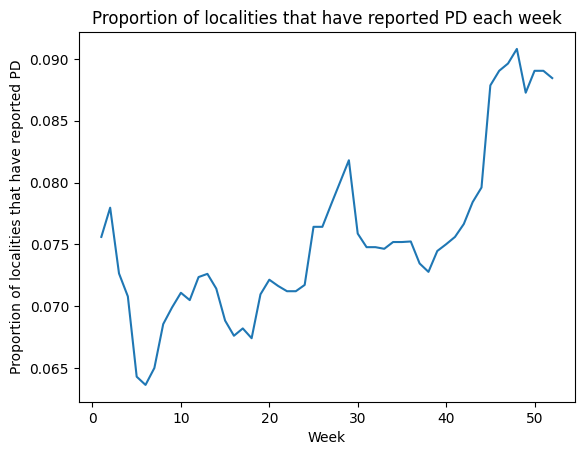

In [47]:
# ran out of time to finish this part, so not going through the database. struggeled to get it to registrer the json file.

# go through yearsummary and find the amount of localities that have reported PD each week
list_pb = []
for i in yearsummary:
    count_pb = 0
    for j in i['localities']:
        if j['hasPd'] == True:
            count_pb += 1
    count_pb = count_pb/len(i['localities'])
    list_pb.append(count_pb)

# plot list_pb
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(1,53)
y = list_pb
plt.plot(x,y)
plt.xlabel('Week')
plt.ylabel('Proportion of localities that have reported PD')
plt.title('Proportion of localities that have reported PD each week')
plt.show()

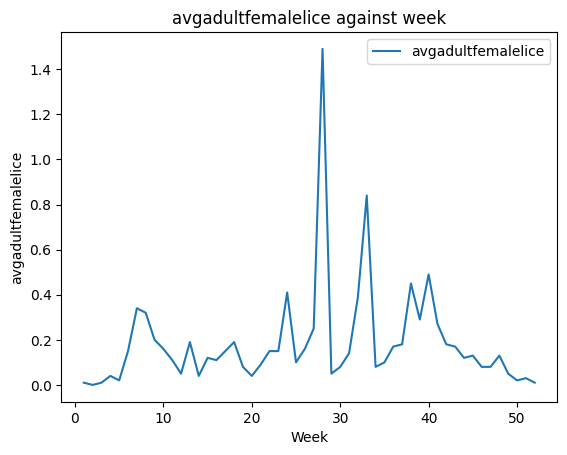

In [72]:
lice_data = spark.read.format("org.apache.spark.sql.cassandra").options(table="table3", keyspace="project1").load().toPandas()

# sort the dataframe by week and set week as index
lice_data = lice_data.sort_values(by=['week'])
lice_data = lice_data.set_index('week')

# plot avgadultfemalelice against week
lice_data.plot(y='avgadultfemalelice')
plt.xlabel('Week')
plt.ylabel('avgadultfemalelice')
plt.title('avgadultfemalelice against week')
plt.show()


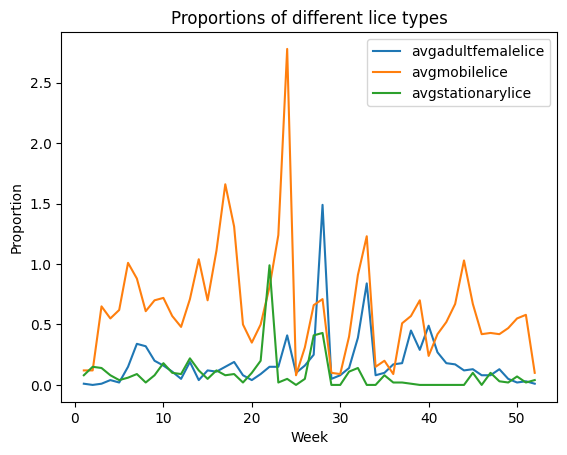

In [76]:
#plot proportions of different lice types
lice_data.plot(y=['avgadultfemalelice', 'avgmobilelice', 'avgstationarylice'])
plt.xlabel('Week')
plt.ylabel('Proportion')
plt.title('Proportions of different lice types')
plt.show()


In [ ]:
# Deleting the keyspace and the table
session.execute("DROP TABLE IF EXISTS project1.table1")
session.execute("DROP TABLE IF EXISTS project1.table2")
session.execute("DROP TABLE IF EXISTS project1.table3")
session.execute("DROP KEYSPACE IF EXISTS project1")

# Closing the connection
session.shutdown()
cluster.shutdown()
spark.stop()